In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import pickle

In [2]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')


mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/home/t.sukanmi/mlops_pratical/experiment_tracking/mlruns/1', creation_time=1715991690099, experiment_id='1', last_update_time=1715991690099, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

### Data preprocessing Feature Engineering

In [3]:
# read dataframe function that read data and performs data preprocessing 
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    
    return df
    
 

In [4]:
# Feeding the data to the function
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

### Vectorization of training data
#### Splitting data to train and test, training the dictionary vectorizer, and tuning the data frame into a feature matrix

In [5]:
df_train

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [6]:
df_train['duration'].describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [7]:
std_dev_january = df_train['duration'].std()
std_dev_january

9.939385620151036

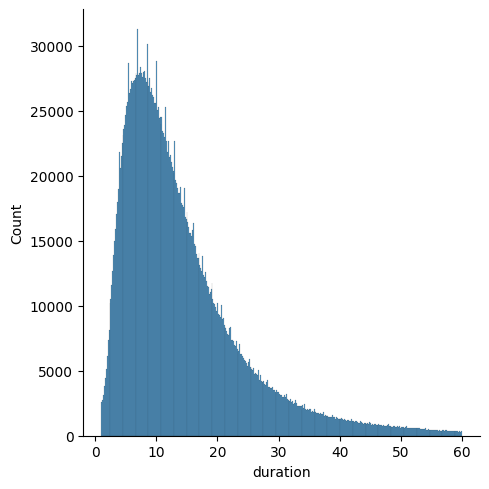

In [8]:
sns.displot(df_train['duration'])

plt.show()

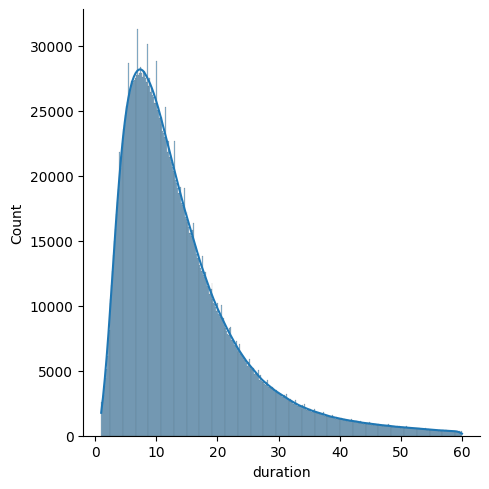

In [9]:
# Define the maximum duration to filter outliers
max_distance = 60

# Filter out the outliers
duration_with_no_outlier = df_train[df_train['duration'] <= max_distance]

# Plot the distribution of durations without outliers
sns.displot(duration_with_no_outlier['duration'], kde=True)

# Show the plot
plt.show()

In [10]:
categorical = ['PULocationID', 'DOLocationID']
target = 'duration'

# Ensure the categorical columns are treated as strings
df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

# Convert the DataFrame to a list of dictionaries
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

# Initialize the DictVectorizer
dv = DictVectorizer()

# Fit and transform the training data
X_train = dv.fit_transform(train_dicts)

# Print the number of encoded features
print(f"The number of matrix-encoded features is: {X_train.shape[1]}")

# Transform the validation data
X_val = dv.transform(val_dicts)

# Extract the target values
y_train = df_train[target].values
y_val = df_val[target].values

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)




The number of matrix-encoded features is: 515


#### Training the model

 Base Model : Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_val_pred = lr.predict(X_val)

y_pred = lr.predict(X_train)






### Evaluating model performance on training and validation set

In [ ]:
# Calculate the Root Mean Squared Error (RMSE)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"base model Root Mean Squared Error on validation set: {val_rmse}")

train_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"base model Root Mean Squared Error on training set: {train_rmse}")

### Displaying the performance of the model

In [ ]:
# Plot the distribution of predicted values
sns.histplot(y_val_pred, kde=True, label='Prediction', color='blue')

# Plot the distribution of actual values
sns.histplot(y_train, kde=True, label='Actual', color='orange')

# Add legend
plt.legend()

plt.show()



In [ ]:
# Plot the distribution of predicted values
sns.histplot(y_pred, kde=True, label='Prediction', color='blue')

# Plot the distribution of actual values
sns.histplot(y_train, kde=True, label='Actual', color='orange')

# Add legend
plt.legend()

# Show the plot

plt.show()

In [ ]:
len(df_train), len(df_val)

In [ ]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_val)

ridge_rmse = mean_squared_error(y_val, ridge_pred, squared=False)
print(f"ridge model Root Mean Squared Error on training set: {ridge_rmse}")

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
las = Lasso(0.01)
las.fit(X_train, y_train)

las_pred = las.predict(X_val)

las_rmse = mean_squared_error(y_val, las_pred, squared=False)
print(f"Lasso model Root Mean Squared Error on training set: {las_rmse}")